**Clayton Davison**
*Homework 3*, *Problem 3*

**CSTR Modeling**

A --> 2B

r = kCa

k obeys Arrhenius equation

In [23]:
'''Parameters input'''

w_flow          =   10.0      # kgmol/s
c_a_in          =   1.2       # kgmol/m^3
c_b_in          =   0.0       # kgmol/m^3
temp_in         =   425.0     # K
volume          =   0.2       # m^3
rho             =   1000.0    # kg/m^3
heat_capacity   =   4184.0    # J/kg/K
enthalpy_rxn    =   6.69e8    # J/kgmol
k_0             =   1.97e24   # 1/s
energy_a_over_r =   20000.0   # K
temp_ss         =   350.0     # K


'''Parameters input dictionary'''
params = dict()

params['w_flow']          =   w_flow
params['c_a_in']          =   c_a_in
params['c_b_in']          =   c_b_in
params['temp_in']         =   temp_in
params['volume']          =   volume
params['rho']             =   rho
params['heat_capacity']   =   heat_capacity
params['enthalpy_rxn']    =   enthalpy_rxn
params['k_0']             =   k_0
params['energy_a_over_r'] =   energy_a_over_r
params['temp_ss']         =   temp_ss


'''Stoichiometric matrix'''
# (A → 2B)
import numpy as np
stoic_mtrx = np.zeros((1,2)) # stoichiometric matrix
stoic_mtrx[0,0] = -1.0
stoic_mtrx[0,1] =  2.0

params['stoic_mtrx'] = stoic_mtrx

import nbconvert

In [24]:
'''ODE RHS function for integrator'''
def f_vec( u_vec, t, params ):
    
    c_a  = u_vec[0]
    c_b  = u_vec[1]
    temp = u_vec[2]
    
    assert c_a  >= 0.0
    assert c_b  >= 0.0
    assert temp >= 0.0
      
    c_a_in          = params['c_a_in'] 
    c_b_in          = params['c_b_in']
    temp_in         = params['temp_in']
    volume          = params['volume']
    rho             = params['rho']
    heat_capacity   = params['heat_capacity']
    enthalpy_rxn    = params['enthalpy_rxn']
    k_0             = params['k_0']
    energy_a_over_r = params['energy_a_over_r']
    
    stoic_mtrx      = params['stoic_mtrx']
    q_flow          = params['q_flow']
    q_dot           = params['q_dot']
    
    import math 
    k = k_0 * math.exp(-energy_a_over_r/temp) # reaction rate constant
    
    import numpy as np
    r_vec = np.zeros(1)
    r_vec[0] = k * c_a   # reaction rate vector
    
    g_vec = stoic_mtrx.transpose() @ r_vec  # species production rates S^T r = g
    
    tau = volume/q_flow # flow residence time
    
    f_0 = - 1/tau*(c_a - c_a_in) + g_vec[0]
    
    f_1 = - 1/tau*(c_b - c_b_in) + g_vec[1]
    
    f_2 = - 1/tau*(temp - temp_in) \
          + 1/rho/heat_capacity*( q_dot/volume - enthalpy_rxn * r_vec[0] )
    
    return np.array([f_0, f_1, f_2])

In [25]:
'''Steady state concentration of A'''

import math

q_flow = w_flow/rho

tau = volume / q_flow

k_cte = k_0 * math.exp( -energy_a_over_r/temp_ss )

c_a_ss = c_a_in / (tau*k_cte + 1)

params['c_a_ss'] = c_a_ss  # save s.s. value in params
params['q_flow'] = q_flow  # save s.s. value in params

print('q (vol. flowrate)         = %5.2e [m^3/s] = %5.2e [L/s]'%(q_flow,q_flow*1000))
print('')
print('Concentration of A @ SS   = %5.2e [kgmol/m^3]'%c_a_ss)
#print('flow residence time (tau) = %5.2e [s]'%(tau))

q (vol. flowrate)         = 1.00e-02 [m^3/s] = 1.00e+01 [L/s]

Concentration of A @ SS   = 1.71e-01 [kgmol/m^3]


In [26]:
'''Steady state concentration of B'''

c_b_ss = c_b_in + tau * 2 * k_cte * c_a_ss

params['c_b_ss'] = c_b_ss # save s.s. value in params

print('Concentration of B @ SS = %5.2e [kgmol/m^3]'%c_b_ss)

Concentration of B @ SS = 2.06e+00 [kgmol/m^3]


In [27]:
'''Steady state heating power'''

q_heat_power_dens_ss = rho*heat_capacity/tau * (temp_ss - temp_in) + enthalpy_rxn * k_cte * c_a_ss

params['q_dot'] = q_heat_power_dens_ss * volume # save s.s. value in params

print('Q(Steady State) = %5.3e [kW] = %5.3e [MW]'%(q_heat_power_dens_ss*volume/1000,q_heat_power_dens_ss*volume/1000000))

Q(Steady State) = 3.744e+03 [kW] = 3.744e+00 [MW]


In [28]:
'''Create the CSTR run function'''

def run_cstr(f_vec, time_stamps, params):
    
    # ODE integrator
    from scipy.integrate import odeint
    
    max_n_steps_per_time_step = 100 # max number of nonlinear algebraic solver iterations per time step

    u_vec_0    = np.zeros(3,dtype=np.float64)
    u_vec_0[0] = params['c_a_ss']
    u_vec_0[1] = params['c_b_ss']
    u_vec_0[2] = params['temp_ss']

    # ODE integrator call
    (u_vec_history, info_dict) = odeint( f_vec, u_vec_0, time_stamps,
                                         args=( params, ),
                                         rtol=1e-7, atol=1e-7, mxstep=max_n_steps_per_time_step,
                                         full_output=True, tfirst=False )

    assert info_dict['message']=='Integration successful.',\
               'Fatal: scipy.integrate.odeint failed %r'%info_dict['message']
    
    return u_vec_history

In [29]:
'''Evolve the CSTR'''

# inflow condition change

params['c_a_in']  = 1.0
params['temp_in'] = 410.0

# run the reactor

time_final   = 10 * tau # number of residence flow times to evolve
n_time_steps = 200      # number of solution values in time

import numpy as np
time_stamps = np.linspace(0.0, time_final, num=n_time_steps) # create time stamps

u_vec_history = run_cstr(f_vec, time_stamps, params)

# print the solution in a tabular form
print('       Time [s]    c_A [kgmol/m^3]  c_B [kgmol/m^3]     T [K]' )
idx = 0
for (t,u) in zip(time_stamps,u_vec_history):
    if idx%5 == 0:
        print('%15.3e %15.3e %15.3e %15.3e'%(t,u[0],u[1],u[2]))
    idx += 1

       Time [s]    c_A [kgmol/m^3]  c_B [kgmol/m^3]     T [K]
      0.000e+00       1.713e-01       2.057e+00       3.500e+02
      5.025e+00       1.487e-01       2.014e+00       3.502e+02
      1.005e+01       1.342e-01       1.974e+00       3.508e+02
      1.508e+01       1.232e-01       1.942e+00       3.513e+02
      2.010e+01       1.148e-01       1.917e+00       3.517e+02
      2.513e+01       1.084e-01       1.897e+00       3.521e+02
      3.015e+01       1.034e-01       1.882e+00       3.524e+02
      3.518e+01       9.966e-02       1.870e+00       3.526e+02
      4.020e+01       9.675e-02       1.860e+00       3.528e+02
      4.523e+01       9.450e-02       1.853e+00       3.529e+02
      5.025e+01       9.276e-02       1.847e+00       3.531e+02
      5.528e+01       9.142e-02       1.842e+00       3.531e+02
      6.030e+01       9.038e-02       1.839e+00       3.532e+02
      6.533e+01       8.957e-02       1.836e+00       3.533e+02
      7.035e+01       8.894e-02       1.83

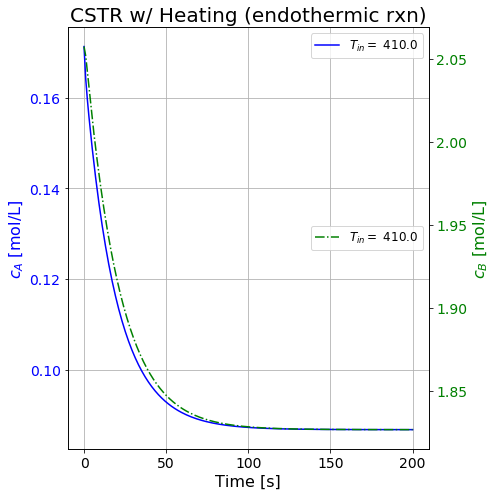

In [30]:
'''Plot Concentration versus Time'''

import matplotlib.pyplot as plt
    
(fig, ax1) = plt.subplots(1, figsize=(7, 7))

ax1.plot(time_stamps,u_vec_history[:,0],'b-',label='$T_{in}=$ '+str(params['temp_in']) )

ax1.set_xlabel(r'Time [s]',fontsize=16)
ax1.set_ylabel(r'$c_A$ [mol/L]',fontsize=16,color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.legend(loc='best',fontsize=12)
#ax1.set_ylim(0,1)
ax1.grid(True)

# create a twin x axis to be shared
ax2 = ax1.twinx() 

ax2.plot( time_stamps , u_vec_history[:,1],'g-.',label='$T_{in}=$ '+str(params['temp_in']) )

ax2.set_ylabel(r'$c_B$ [mol/L]',fontsize=16,color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
ax2.legend(loc='center right',fontsize=12)
#ax2.set_ylim(0,2)
#ax2.grid(True)

plt.title('CSTR w/ Heating (endothermic rxn)',fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
print('')

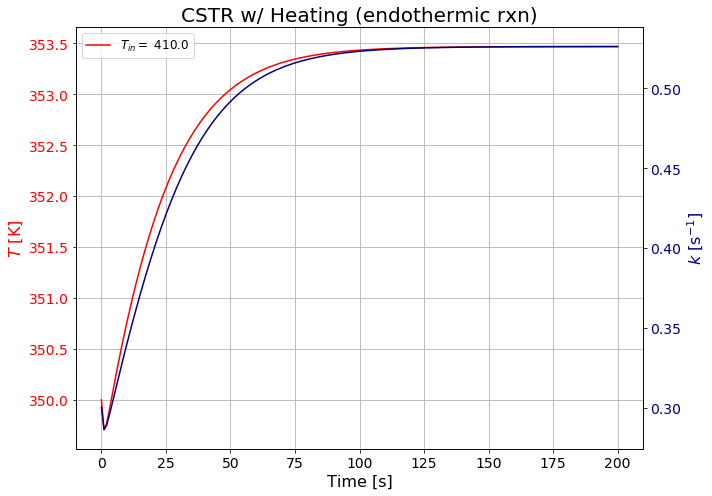

In [31]:
import matplotlib.pyplot as plt
    
(fig, ax1) = plt.subplots(1, figsize=(10, 7))

ax1.plot(time_stamps,u_vec_history[:,2],'r-',label='$T_{in}=$ '+str(params['temp_in']) )

ax1.set_xlabel(r'Time [s]',fontsize=16)
ax1.set_ylabel(r'$T$ [K]',fontsize=16,color='red')
ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.legend(loc='upper left',fontsize=12)
ax1.grid(True)

ax2 = ax1.twinx() 
k_cte = params['k_0']*np.exp(-params['energy_a_over_r']/u_vec_history[:,2])
ax2.plot(time_stamps,k_cte,'-',color='navy',label='$T_{in}=$ '+str(params['temp_in']) )
ax2.set_ylabel(r'$k$ [s$^{-1}$]',fontsize=16,color='navy')
ax2.tick_params(axis='y', labelcolor='navy', labelsize=14)
#ax2.legend(loc='best',fontsize=14)
#ax2.grid(True)


plt.title('CSTR w/ Heating (endothermic rxn)',fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
print('')